# Converting phi-psi curves into beta-zeta curves

Import some standard python libraries that we need:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

`getZeta` is a function that takes phi and psi (arrays) as input, and returns zeta and beta (arrays). To do this, we need information about the gas (cp and gamma) and about the non-dimensional shaft speed (we provide this as inlet stagnation conditions and blade speed), and inlet swirl. This is a compressible calculation at needs iteration:

In [18]:
def getZeta(phi, psi, beta2, T01, p01, alpha1, U, cp, ga):
    cv = cp / ga                 # work out cv and R from cp and ga
    rgas = cp - cv               
    beta1 = np.zeros(len(phi))   # initialise our output arrays
    zeta  = np.zeros(len(phi))
    #
    # loop over each point on the phi-psi characteristic
    #
    for indx, phi in enumerate(phi):
        vx1   = phi * np.abs(U)             # inlet axial velocity
        vt1   = vx1 * np.tan(alpha1)        # inlet tangential velocity
        v1sq  = vx1**2 + vt1**2             
        T1    = T01 - 0.5*v1sq/cp           # inlet static T
        p1    = p01 * (T1/T01)**(ga/(ga-1)) # inlet static p
        ro1   = p1/(rgas*T1)                # inlet density
        p2    = psi[indx]*ro1*U**2 + p01    # outlet static p
        ro2guess = ro1                      # guess outlet density
        conv  = 1E9
        #
        # convergence loop
        #
        while (conv>0.000001):
            ro2    = ro2guess               # set the outlet density to our guess
            vx2    = ro1*vx1 / ro2          # outlet axial velocity
            vt2rel = vx2 * np.tan(beta2)    # outlet relative tangential velocity
            vt2    = vt2rel + U             # outlet tangential velocity
            v2sq   = vx2**2 + vt2**2
            T02    = T01 + U*(vt2-vt1)/cp   # outlet stagnation T
            T2     = T02 - 0.5*v2sq/cp      
            ro2guess = p2/(rgas*T2)         # hence a new guess of outlet density
            conv   = np.abs( (ro2-ro2guess)/ro2 )
        #
        # now we have converged, we need to evaluate zeta
        #
        vt1rel = vt1 - U                              # upstream relative tangential v
        v1relsq = vx1**2 + vt1rel**2                  # upstream relative v^2
        dels = cp*np.log(T2/T1) - rgas*np.log(p2/p1)  # change in entropy
        zeta_now = (T1*dels)/(0.5*v1relsq)            # loss coefficient, zeta
        beta1_now = np.arctan2(vt1rel,vx1)            # inlet angle, beta
        beta1[indx] = beta1_now
        zeta[indx] = zeta_now
    return zeta, beta1

Test this on a sample phi-psi chic:

In [21]:
#
# Use the Moore-Greizter cubic definition as test. Set the
# constants to align with some test data from Whittle Lab
#
phi_W = np.linspace(0.,3.,500)    
psi0_H = 0.
psi_H = psi0_H + (1 + 1.5*(phi_W - 1) - 0.5*(phi_W - 1)**3)

H_W=0.5 * 0.41/0.370   # to align with test data
W=0.370/2.

phi = phi_W * W
psi = psi_H * H_W * W

Plot the sample phi-psi characteristic:

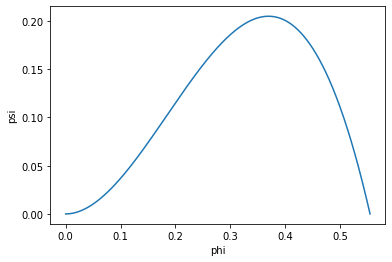

In [16]:
plt.plot(phi,psi)
plt.xlabel("phi")
plt.ylabel("psi");

To set the non-dimensional blade speed, we take our high radius test case (very high hub-to-tip radius ratio), and set the inlet stagnation conditions. We also set the outlet relative flow angle.

In [10]:
rtip = 634.894653  
rhub = 634.831177
rmid = 0.5*(rhub+rtip)
beta2_mid_deg = 51.45
beta2_mid = beta2_mid_deg / 180. * np.pi
T01 = 300.
p01 = 100000.
alpha1 = 0. 
wrad = -0.125684455 
Umid = wrad*rmid
cp = 1005.
ga = 1.4
rgas = cp - cp /ga

Use `getZeta` to convert to beta-zeta

In [11]:
zeta, beta = getZeta( phi, psi, beta2_mid, T01, p01, alpha1, Umid, cp, ga)

and plot the result:

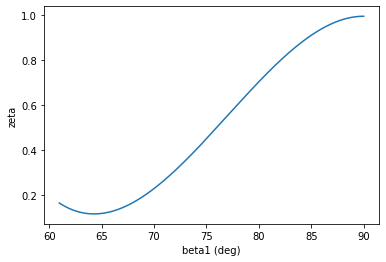

In [15]:
plt.plot(beta/np.pi*180,zeta)
plt.xlabel("beta1 (deg)")
plt.ylabel("zeta");